In [19]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [20]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs)

In [21]:
data = load_data(pathlib.Path('../runs-prod/action-throughput-v1/'))

framework,actions_per_actor,num_nodes,num_workers_per_node,num_actors,runtime
str,i64,i64,i64,i64,f64
"""aeris""",100,64,52,3328,93.132063
"""aeris""",100,16,52,832,23.334325
"""aeris""",100,1,52,52,1.463471
"""dask""",100,8,52,416,228.519446
"""aeris""",100,32,52,1664,46.671939
"""dask""",100,1,52,52,18.580084
"""ray""",100,64,52,3328,25.874284
"""dask""",100,2,52,104,50.161907
"""ray""",100,2,52,104,0.588787


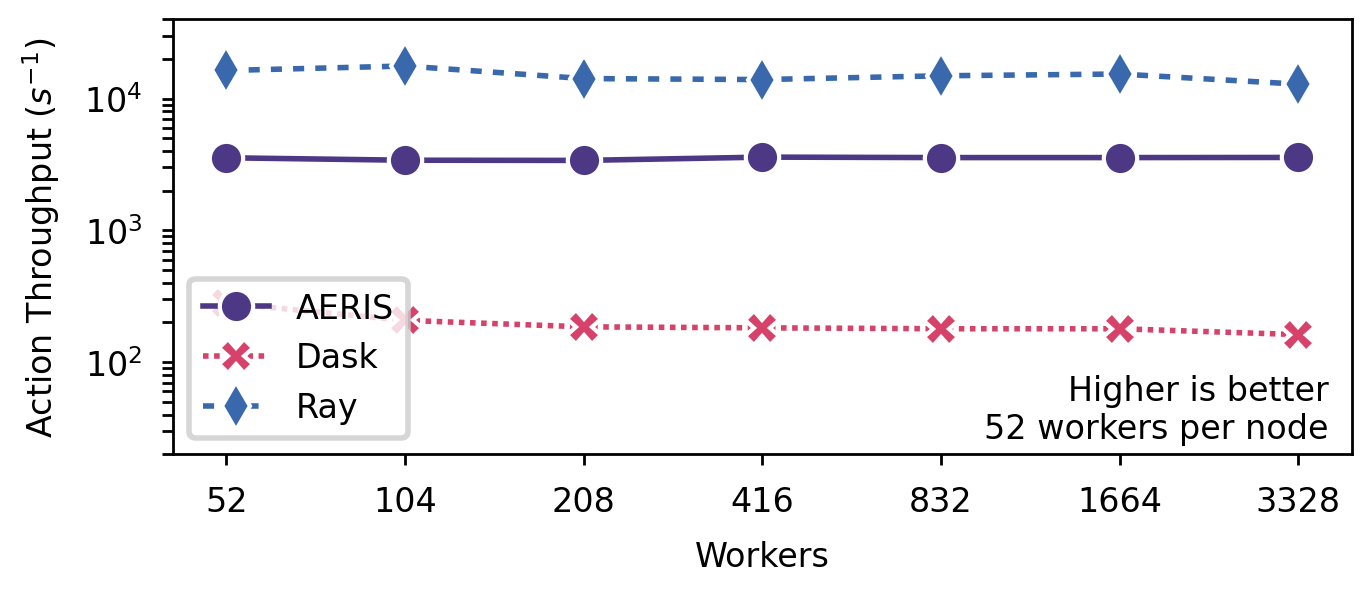

In [35]:
fig, axs = plt.subplots(1, 1)

results = data.with_columns(
    (
        polars.col('num_actors')
        * polars.col('actions_per_actor')
        / polars.col('runtime')
    ).alias('throughput'),
)

xticks = sorted(set(results['num_actors'].to_list()))
dashes = {
    'ray': (2, 2),
    'dask': (1, 1),
    'aeris': (),
}
markers = {'ray': 'd', 'dask': 'X', 'aeris': 'o'}
palette = {'ray': '#3969AC', 'dask': '#D64269', 'aeris': '#4D3886'}

handle = seaborn.lineplot(
    results,
    x='num_actors',
    y='throughput',
    hue='framework',
    hue_order=['ray', 'dask', 'aeris'],
    # errorbar='sd',
    # err_style='bars',
    style='framework',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    loc='lower left',
    handles=handles[::-1],
    title=None,
    labels=['AERIS', 'Dask', 'Ray'],
)
_ = handle.set(
    xscale='log',
    yscale='log',
    xlabel='Workers',
    ylabel='Action Throughput ($s^{-1}$)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
axs.tick_params(axis='x', which='minor', bottom=False)
axs.set(ylim=[20, 40000])

axs.annotate(
    'Higher is better\n52 workers per node',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

# fig.tight_layout(w_pad=1)
fig.set_size_inches(3.35, 1.25)
fig.savefig('figures/actor-action-throughput.pdf')